# Fully Connected Experiments on FashionMNIST with a standardized minimized setup


## 1. Setup

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns

from copy import deepcopy
from IPython import display
from random import uniform
from semitorch import (
    MaxPlus, maxplus_parameters, nonmaxplus_parameters,
    MinPlus, minplus_parameters, nonminplus_parameters,
    SemiLog, semilog_parameters, nonsemilog_parameters,
)
from statistics import quantiles
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import trange

device = "cuda" if torch.cuda.is_available() else "cpu"

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.7
[Taichi] Starting on arch=cuda


### Load FashionMNIST data

In [2]:
batch_size = 256
num_workers = 8

transforms_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
    ]
)

fmnist_trainset = FashionMNIST(root=".", train=True, download=True, transform=transforms_train)
fmnist_testset = FashionMNIST(root=".", train=False, download=True, transform=transforms_test)

fmnist_trainloader = DataLoader(fmnist_trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
fmnist_testloader = DataLoader(fmnist_testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## 2. Models

In [3]:
class Model(nn.Module):
    def __init__(self, model_name: str, mu: float = None) -> None:
        super().__init__()
        self.name = model_name

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, stride=4),
            nn.Flatten(),
        )

        if model_name == "linear/relu":
            self.backbone_1 = nn.Sequential(
                nn.Linear(8 * 7 * 7, 300), nn.ReLU(),
                nn.Linear(300, 250), nn.ReLU(),
            )
            self.backbone_2 = nn.Sequential(
                nn.Linear(250, 200), nn.ReLU(),
                nn.Linear(200, 150), nn.ReLU(),
            )
            self.backbone_3 = nn.Sequential(
                nn.Linear(150, 100), nn.ReLU(),
                nn.Linear(100, 50), nn.ReLU(),
            )
        elif model_name == "linear/maxplus":
            self.backbone_1 = nn.Sequential(
                MaxPlus(8 * 7 * 7, 300),
                nn.Linear(300, 250),
            )
            self.backbone_2 = nn.Sequential(
                MaxPlus(250, 200),
                nn.Linear(200, 150),
            )
            self.backbone_3 = nn.Sequential(
                MaxPlus(150, 100),
                nn.Linear(100, 50),
            )
        elif model_name == "linear/minplus":
            self.backbone_1 = nn.Sequential(
                MinPlus(8 * 7 * 7, 300),
                nn.Linear(300, 250),
            )
            self.backbone_2 = nn.Sequential(
                MinPlus(250, 200),
                nn.Linear(200, 150),
            )
            self.backbone_3 = nn.Sequential(
                MinPlus(150, 100),
                nn.Linear(100, 50),
            )
        elif model_name == "linear/log":
            self.backbone_1 = nn.Sequential(
                SemiLog(8 * 7 * 7, 300, mu=mu),
                nn.Linear(300, 250),
            )
            self.backbone_2 = nn.Sequential(
                SemiLog(250, 200, mu=mu),
                nn.Linear(200, 150),
            )
            self.backbone_3 = nn.Sequential(
                SemiLog(150, 100, mu=mu),
                nn.Linear(100, 50),
            )
        else:
            raise RuntimeError(f"Unknown model ({model_name})")

        self.head = nn.Linear(50, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_0 = x
        result_0 = self.stem(input_0)

        input_1 = result_0
        result_1 = self.backbone_1(input_1)

        input_2 = result_1
        result_2 = self.backbone_2(input_2)

        input_3 = result_2
        result_3 = self.backbone_3(input_3)

        output = self.head(result_3)

        return output

In [4]:
def count_parameters(parameters) -> int:
    return sum(p.numel() for p in parameters if p.requires_grad)

## 3. Training

In [5]:
def accuracy(model: nn.Module, x: torch.Tensor, y: torch.Tensor) -> float:
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)

        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model: nn.Module, testloader: DataLoader) -> float:
    model.eval()
    accs = []

    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))

    return sum(accs) / len(accs)


def confusion_matrix(model: nn.Module, testloader: DataLoader) -> None:
    model.eval()

    conf_matrix = torch.zeros(len(fmnist_testset.classes), len(fmnist_testset.classes))

    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)

            conf_matrix[y.cpu(), prediction] += 1

    plt.figure(figsize=(6, 4))

    df_cm = pd.DataFrame(conf_matrix, index=fmnist_testset.classes, columns=fmnist_testset.classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def train(
        model: nn.Module,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        loss: torch.nn.modules.loss,
        epochs: int,
        statistics_mode: bool = False  # If True: (return max acc and do not generate output)
) -> None | float:
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches

    if not statistics_mode:
        fig, ax = plt.subplots(1, 1, figsize=[6, 4])
        hdisplay = display.display("", display_id=True)

    for _ in trange(epochs):
        model.train()

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            for optimizer in optimizers:
                optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))

            l = loss(yout, y.squeeze())
            l.backward()
            for optimizer in optimizers:
                optimizer.step()

        accs.append(test(model, testloader))

        if not statistics_mode:
            ax.clear()
            ax.set_xlim(0, epochs)
            ax.set_ylim(-0.02, 1.02)
            ax.plot(
                np.linspace(0, len(accs), len(trainaccs)),
                trainaccs,
                ".",
                markersize=1.5,
                markerfacecolor=(0, 0, 1, 0.3),
            )
            ax.plot(np.linspace(1, len(accs), len(accs)), accs)
            ax.text(
                0.6 * epochs,
                0.30,
                f"max test acc = {max(accs):.2%}",
                ha="center",
                fontsize=10,
            )
            hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    if not statistics_mode:
        confusion_matrix(model, testloader)
        
    if statistics_mode:
        return max(accs)

In [6]:
def run_model_for_config(config: dict, best_accuracy: float) -> dict:
    loss = nn.CrossEntropyLoss()
    epochs = 20

    # Create model
    model_name = config["model_name"]
    linear_lr = config["linear_lr"]
    semiring_lr = config["semiring_lr"]
    mu = config["mu"]

    model = Model(model_name=model_name, mu=mu).to(device)

    # Separate model parameters
    if model_name == "linear/relu":
        linear_params = model.parameters()
        semiring_params = nn.ParameterList()
    elif model_name == "linear/maxplus":
        linear_params = nonmaxplus_parameters(model)
        semiring_params = maxplus_parameters(model)
    elif model_name == "linear/minplus":
        linear_params = nonminplus_parameters(model)
        semiring_params = minplus_parameters(model)
    elif model_name == "linear/log":
        linear_params = nonsemilog_parameters(model)
        semiring_params = semilog_parameters(model)
    else:
        raise RuntimeError(f"Unknown model ({model_name})")

    # Create linear optimizer
    linear_optimizer = torch.optim.AdamW(linear_params, lr=linear_lr)

    # Create semiring optimizer
    if model_name == "linear/relu":
        semiring_optimizer = None
    else:
        semiring_optimizer = torch.optim.AdamW(semiring_params, lr=semiring_lr)

    # Create optimizers
    optimizers = list(filter(lambda opt: opt is not None, [linear_optimizer, semiring_optimizer]))

    reported_accuracy, last_reported_accuracy = [[], []], [[], []]
    for attempt in range(2):  # Run twice to detect and filter out anomalies
        reported_accuracy[attempt], last_reported_accuracy[attempt] = 0, 0
        for epoch in range(epochs):
            last_reported_accuracy[attempt] = reported_accuracy[attempt]
    
            # Feed to training function
            reported_accuracy[attempt] = train_model(
                model,
                fmnist_trainloader,
                fmnist_testloader,
                optimizers,
                loss,
            )
    
            # Try some stopping conditions
            if (((epoch > 2) and (reported_accuracy[attempt] < 0.15))
                    or ((epoch > 5) and (reported_accuracy[attempt] < best_accuracy / 2))
                    or ((epoch > 2) and (abs(last_reported_accuracy[attempt] - reported_accuracy[attempt]) < 1e-6))):
                # Run is done, no sense to train it any further
                # or bad trial
                break  # Break for-loop to report

    return {"accuracy": min(reported_accuracy), "config": config}


def train_model(
        model: nn.Module,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        loss: torch.nn.modules.loss,
) -> float:
    model.train()

    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        for optimizer in optimizers:
            optimizer.zero_grad()

        l = loss(model(x), y.squeeze())
        l.backward()

        for optimizer in optimizers:
            optimizer.step()

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    return test(model, testloader)


def run_random_search_for_config(config: dict) -> dict:
    best_accuracy, best_config, current_config = 0, deepcopy(config), deepcopy(config)
    step_size, bad_step_counter, good_step_counter = 0.1, 0, 0
    for _ in range(100):
        result = run_model_for_config(current_config, best_accuracy=best_accuracy)

        if result["accuracy"] > best_accuracy:
            bad_step_counter = 0
            good_step_counter += 1

            best_accuracy, best_config = result["accuracy"], deepcopy(current_config)
        else:
            bad_step_counter += 1
            good_step_counter = 0

        if bad_step_counter > 10:
            break  # Terminate run, likely no better accuracy possible

        current_config, step_size, bad_step_counter, good_step_counter = adaptive_step_update_config(
            config=deepcopy(best_config),
            step_size=step_size,
            bad_step_counter=bad_step_counter,
            good_step_counter=good_step_counter,
        )

        if step_size < 1e-2:
            # Step size too small to make any impact, terminate run
            break

    return {"accuracy": best_accuracy, "config": best_config}


def adaptive_step_update_config(
        config: dict,
        step_size: float,
        bad_step_counter: int,
        good_step_counter: int,
) -> tuple[dict, float, int, int]:
    # Update step_size
    if bad_step_counter > 2:
        step_size /= 2
        bad_step_counter = 0
    if (good_step_counter > 2) and (step_size < 0.5):
        step_size *= 2
        good_step_counter = 0

    # Update config values
    config["linear_lr"] = uniform(
        config["linear_lr"] * (1 - step_size),
        config["linear_lr"] * (1 + step_size),
    )
    if config["model_name"] != "linear/relu":
        config["semiring_lr"] = uniform(
            config["semiring_lr"] * (1 - step_size),
            config["semiring_lr"] * (1 + step_size),
        )

    return config, step_size, bad_step_counter, good_step_counter


def find_best_model_for(config: dict) -> None:
    result = {"accuracy": 0, "config": {}}
    while result["accuracy"] < 0.5:
        current_config = create_random_config_for_model(deepcopy(config))
    
        print(f"Starting run for config {current_config}")
        result = run_random_search_for_config(current_config)

    display.clear_output(wait=True)
    print(result)
    
def create_random_config_for_model(config: dict) -> dict:
    config["linear_lr"] = 10 ** uniform(-3, -1)
    if config["model_name"] != "linear/relu":
        config["semiring_lr"] = 10 ** uniform(-3, -1)

    return config

# Linear

In [32]:
find_best_model_for(config={
    "model_name": "linear/relu",
    "semiring_lr": None,
    "mu": None,
})

{'accuracy': 0.8892578125, 'config': {'model_name': 'linear/relu', 'linear_lr': 0.0010659631874881759, 'semiring_lr': None, 'mu': None}}


linear/relu model has 294286 trainable parameters


''

  0%|          | 0/20 [00:00<?, ?it/s]

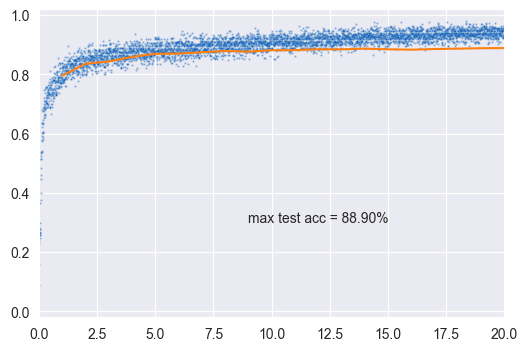

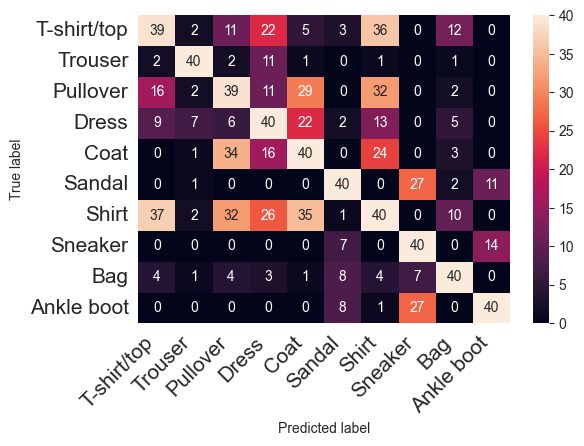

In [7]:
best_linear_model = Model(model_name="linear/relu").to(device)
print(f"{best_linear_model.name} model has {count_parameters(best_linear_model.parameters())} trainable parameters")

best_linear_optimizer = torch.optim.AdamW(best_linear_model.parameters(), lr=0.0010659631874881759)

train(
    best_linear_model,
    fmnist_trainloader,
    fmnist_testloader,
    [best_linear_optimizer],
    nn.CrossEntropyLoss(),
    20,
)

In [9]:
best_linear_model_accs = []
for i in range(100):
    print(i)
    
    best_linear_model = Model(model_name="linear/relu").to(device)
    
    best_linear_optimizer = torch.optim.AdamW(best_linear_model.parameters(), lr=0.0010659631874881759)
    
    best_linear_model_accs.append(train(
        best_linear_model,
        fmnist_trainloader,
        fmnist_testloader,
        [best_linear_optimizer],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(best_linear_model_accs))
print(quantiles(best_linear_model_accs))
print(max(best_linear_model_accs))

0.8859375
[0.8891845703125, 0.8904785156249999, 0.8916748046875]
0.89658203125


# MaxPlus

In [7]:
find_best_model_for(config={
    "model_name": "linear/maxplus",
    "mu": None,
})

{'accuracy': 0.86376953125, 'config': {'model_name': 'linear/maxplus', 'mu': None, 'linear_lr': 0.0046864937436538944, 'semiring_lr': 0.00311706907651238}}


linear/maxplus model has 294286 trainable parameters, of which 111086 are linear and 183200 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

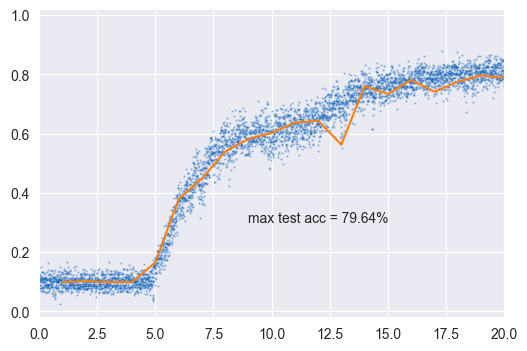

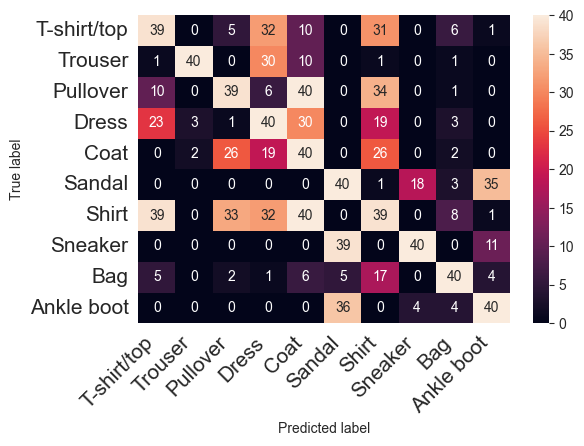

In [10]:
best_maxplus_model = Model("linear/maxplus").to(device)

print(f"{best_maxplus_model.name} model has {count_parameters(best_maxplus_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonmaxplus_parameters(best_maxplus_model))} are linear "
      f"and {count_parameters(maxplus_parameters(best_maxplus_model))} are semiring related")

best_maxplus_linear_optimizer = torch.optim.AdamW(nonmaxplus_parameters(best_maxplus_model), lr=0.0046864937436538944)
best_maxplus_semiring_optimizer = torch.optim.AdamW(maxplus_parameters(best_maxplus_model), lr=0.00311706907651238)

best_maxplus_optimizers = [best_maxplus_linear_optimizer, best_maxplus_semiring_optimizer]

train(
    best_maxplus_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_maxplus_optimizers,
    nn.CrossEntropyLoss(),
    20,
)

In [11]:
best_maxplus_model_accs = []
for i in range(100):
    print(i)
    
    best_maxplus_model = Model("linear/maxplus").to(device)

    best_maxplus_linear_optimizer = torch.optim.AdamW(nonmaxplus_parameters(best_maxplus_model), lr=0.0046864937436538944)
    best_maxplus_semiring_optimizer = torch.optim.AdamW(maxplus_parameters(best_maxplus_model), lr=0.00311706907651238)
    
    best_maxplus_optimizers = [best_maxplus_linear_optimizer, best_maxplus_semiring_optimizer]
    
    best_maxplus_model_accs.append(train(
        best_maxplus_model,
        fmnist_trainloader,
        fmnist_testloader,
        best_maxplus_optimizers,
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)
    
print(min(best_maxplus_model_accs))
print(quantiles(best_maxplus_model_accs))
print(max(best_maxplus_model_accs))

0.61572265625
[0.7432617187500001, 0.823046875, 0.8485107421875]
0.87353515625


# MinPlus

In [8]:
find_best_model_for(config={
    "model_name": "linear/minplus",
    "mu": None,
})

{'accuracy': 0.85009765625, 'config': {'model_name': 'linear/minplus', 'mu': None, 'linear_lr': 0.004195669820145525, 'semiring_lr': 0.012090736153612062}}


linear/minplus model has 294286 trainable parameters, of which 111086 are linear and 183200 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

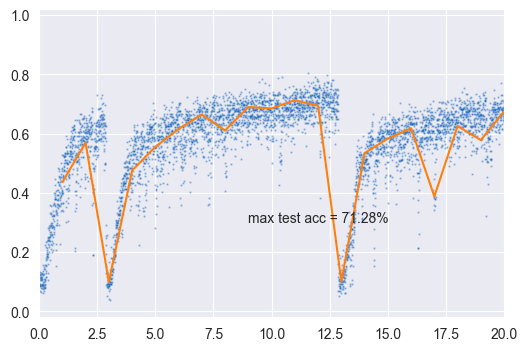

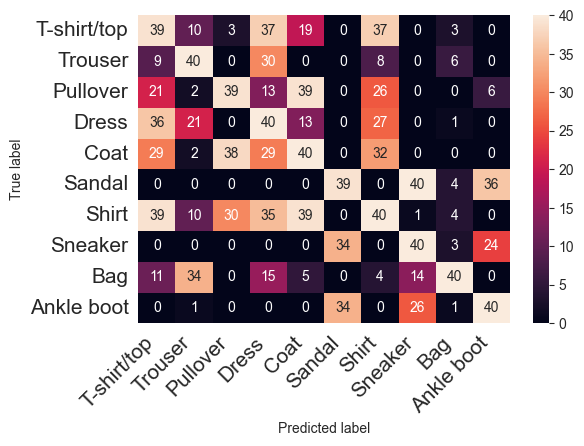

In [12]:
best_minplus_model = Model("linear/minplus").to(device)

print(f"{best_minplus_model.name} model has {count_parameters(best_minplus_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonminplus_parameters(best_minplus_model))} are linear "
      f"and {count_parameters(minplus_parameters(best_minplus_model))} are semiring related")

best_minplus_linear_optimizer = torch.optim.AdamW(nonminplus_parameters(best_minplus_model), lr=0.004195669820145525)
best_minplus_semiring_optimizer = torch.optim.AdamW(minplus_parameters(best_minplus_model), lr=0.012090736153612062)

best_minplus_optimizers = [best_minplus_linear_optimizer, best_minplus_semiring_optimizer]

train(
    best_minplus_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_minplus_optimizers,
    nn.CrossEntropyLoss(),
    20,
)

In [13]:
best_minplus_model_accs = []
for i in range(100):
    print(i)
    
    best_minplus_model = Model("linear/minplus").to(device)

    best_minplus_linear_optimizer = torch.optim.AdamW(nonminplus_parameters(best_minplus_model), lr=0.004195669820145525)
    best_minplus_semiring_optimizer = torch.optim.AdamW(minplus_parameters(best_minplus_model), lr=00.012090736153612062)
    
    best_minplus_optimizers = [best_minplus_linear_optimizer, best_minplus_semiring_optimizer]
    
    best_minplus_model_accs.append(train(
        best_minplus_model,
        fmnist_trainloader,
        fmnist_testloader,
        best_minplus_optimizers,
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)
    
print(min(best_minplus_model_accs))
print(quantiles(best_minplus_model_accs))
print(max(best_minplus_model_accs))

0.68935546875
[0.7998779296875, 0.837744140625, 0.8568115234375]
0.87900390625


# Log semiring

In [ ]:
find_best_model_for(config={
    "model_name": "linear/log",
    "mu": 1.0,
})

In [ ]:
best_semilog_model = Model("linear/log", mu=1.0).to(device)

print(f"{best_semilog_model.name} model has {count_parameters(best_semilog_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonsemilog_parameters(best_semilog_model))} are linear "
      f"and {count_parameters(semilog_parameters(best_semilog_model))} are semiring related")

best_semilog_linear_optimizer = torch.optim.AdamW(nonsemilog_parameters(best_semilog_model), lr=0.00355704371612763)
best_semilog_semiring_optimizer = torch.optim.AdamW(semilog_parameters(best_semilog_model), lr=0.08214756709323294)

best_semilog_optimizers = [best_semilog_linear_optimizer, best_semilog_semiring_optimizer]

train(
    best_semilog_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_semilog_optimizers,
    nn.CrossEntropyLoss(),
    20,
)

In [ ]:
best_semilog_model_accs = []
for i in range(100):
    print(i)
    
    best_semilog_model = Model("linear/log", mu=1.0).to(device)

    best_semilog_linear_optimizer = torch.optim.AdamW(nonsemilog_parameters(best_semilog_model), lr=0.00355704371612763)
    best_semilog_semiring_optimizer = torch.optim.AdamW(semilog_parameters(best_semilog_model), lr=0.08214756709323294)
    
    best_semilog_optimizers = [best_semilog_linear_optimizer, best_semilog_semiring_optimizer]
    
    best_semilog_model_accs.append(train(
        best_semilog_model,
        fmnist_trainloader,
        fmnist_testloader,
        best_semilog_optimizers,
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)
    
print(min(best_semilog_model_accs))
print(quantiles(best_semilog_model_accs))
print(max(best_semilog_model_accs))

In [ ]:
find_best_model_for(config={
    "model_name": "linear/log",
    "mu": -1.0,
})

In [ ]:
best_semilog_model = Model("linear/log", mu=-1.0).to(device)

print(f"{best_semilog_model.name} model has {count_parameters(best_semilog_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonsemilog_parameters(best_semilog_model))} are linear "
      f"and {count_parameters(semilog_parameters(best_semilog_model))} are semiring related")

best_semilog_linear_optimizer = torch.optim.AdamW(nonsemilog_parameters(best_semilog_model), lr=0.0028060615968982165)
best_semilog_semiring_optimizer = torch.optim.AdamW(semilog_parameters(best_semilog_model), lr=0.09543335848738241)

best_semilog_optimizers = [best_semilog_linear_optimizer, best_semilog_semiring_optimizer]

train(
    best_semilog_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_semilog_optimizers,
    nn.CrossEntropyLoss(),
    20,
)

In [ ]:
best_semilog_model_accs = []
for i in range(100):
    print(i)

    best_semilog_model = Model("linear/log", mu=-1.0).to(device)

    best_semilog_linear_optimizer = torch.optim.AdamW(nonsemilog_parameters(best_semilog_model), lr=0.0028060615968982165)
    best_semilog_semiring_optimizer = torch.optim.AdamW(semilog_parameters(best_semilog_model), lr=0.09543335848738241)

    best_semilog_optimizers = [best_semilog_linear_optimizer, best_semilog_semiring_optimizer]

    best_semilog_model_accs.append(train(
        best_semilog_model,
        fmnist_trainloader,
        fmnist_testloader,
        best_semilog_optimizers,
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))

    display.clear_output(wait=True)

print(min(best_semilog_model_accs))
print(quantiles(best_semilog_model_accs))
print(max(best_semilog_model_accs))